In [1]:
import torch # pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, os, json, gc
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils.Network.index import ModelNetwork
from utils.Files import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

gc.collect()
print(torch.__version__)              # versão do PyTorch
print(torch.cuda.is_available())      # True se detectou a GPU
print(torch.cuda.get_device_name(0))  # nome da GPU
pd.set_option('display.max_columns', None)

2.7.1+cu118
True
Quadro P6000


In [3]:
with open(f'database/info.json', 'r', encoding='utf-8') as file:
    processing_options = json.load(file)

processing_options

{'dataset': 'dataset1',
 'tile_size': 0,
 'img_size': 128,
 'n_aug': 0,
 'n_images': 595,
 'multiclass': True}

# CARREGANDO IMAGENS

In [4]:
xTrain = np.array([np.load(path) for path in getFiles('database/processed/train/images')])
yTrain = np.array([np.load(path) for path in getFiles('database/processed/train/masks')])

xVal = np.array([np.load(path) for path in getFiles('database/processed/val/images')])
yVal = np.array([np.load(path) for path in getFiles('database/processed/val/masks')])

limits = float(np.min(xVal)), float(np.max(xVal))
unique = np.unique(yTrain).astype(int)

print('xTrain Shape: ', xTrain.shape)
print('yTrain Shape: ', yTrain.shape)
print('xTrain Range: ',  limits)
print('yTrain Unique: ', unique)

xTrain Shape:  (475, 128, 128, 128)
yTrain Shape:  (475, 128, 128, 128)
xTrain Range:  (0.0, 1.0)
yTrain Unique:  [0 1 2 3 4 5]


In [5]:
MULTCLASS = processing_options.get('multiclass')
classes   = 1 if not MULTCLASS else int(np.max(unique)) + 1
classes

6

In [6]:
IMG_SIZE = xTrain.shape[-1]
print('image size:', IMG_SIZE)
print('classes:', classes)

image size: 128
classes: 6


- exibição imagens

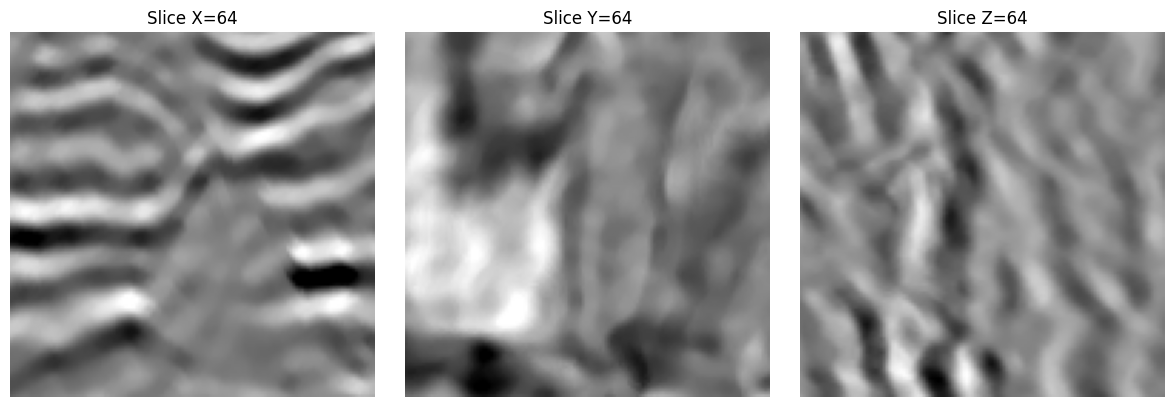

In [7]:
showTile(xTrain[30])

- Exibição Máscaras

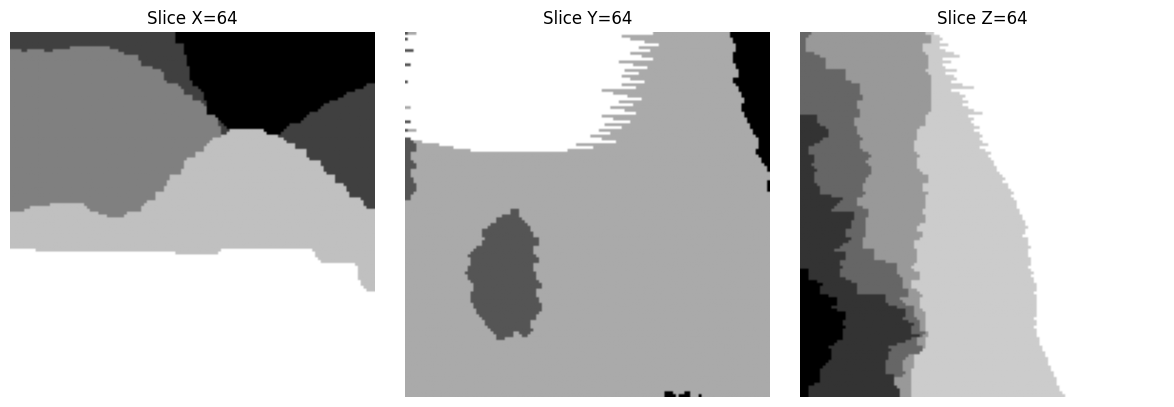

In [8]:
showTile(yTrain[30])

- Alvo (Junção Máscara-Imagem)

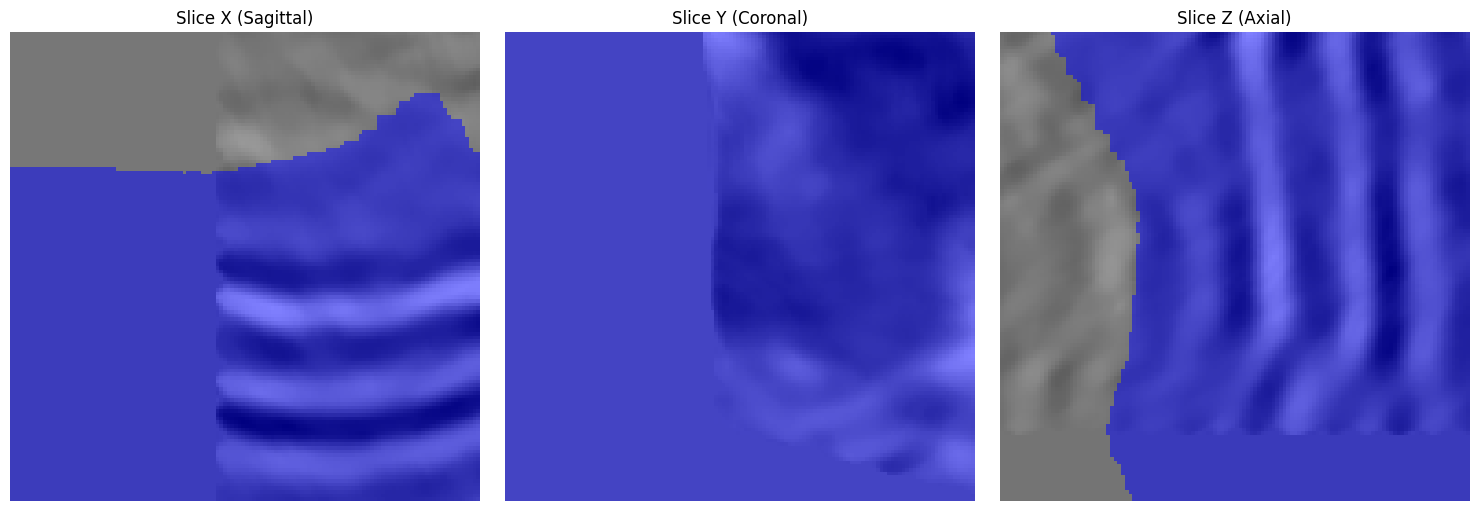

In [9]:
pasteMask(xTrain[0], yTrain[0])

# MODELO

In [10]:
network = ModelNetwork('segresnet', img_size=IMG_SIZE, classes=classes, channels=1)
network.model

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

In [11]:
def getLoader(xData, yData, batch, shuffle=False):
    xTensor = torch.from_numpy(xData).float()
    yTensor = torch.from_numpy(yData).long() if MULTCLASS else torch.from_numpy(yData).float()

    if xTensor.ndim == 4:
        xTensor = xTensor.unsqueeze(1)
    
    if yTensor.ndim == 4: 
        yTensor = yTensor.unsqueeze(1)
    
    dataset = TensorDataset(xTensor, yTensor)
    return DataLoader(dataset, batch_size=batch, shuffle=shuffle, pin_memory=True)


batch_size   = 4
train_loader = getLoader(xTrain, yTrain, batch_size, shuffle=True)
del xTrain, yTrain
val_loader   = getLoader(xVal,   yVal,   batch_size, shuffle=False)
del xVal, yVal

xb, yb = next(iter(train_loader))
print('train X:', xb.shape, xb.dtype) 
print('train Y:', yb.shape, yb.dtype) 

train X: torch.Size([4, 1, 128, 128, 128]) torch.float32
train Y: torch.Size([4, 1, 128, 128, 128]) torch.int64


# FUNÇÃO DE PERDA

In [12]:
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import amp
from utils.EarlyStopping import EarlyStopping
from utils.Metrics import *
from utils.Losses.index import Losses

In [13]:
selected_loss = 'dice_focal'
criterion     = Losses(selected_loss, multiclass=MULTCLASS)
criterion

MultiClassDiceFocalLoss(
  (_loss): DiceFocalLoss(
    (dice): DiceLoss()
    (focal): FocalLoss()
  )
)

# TREINAMENTO

In [14]:
gc.collect()

20218

In [ ]:
class Trainer:
    def __init__(self, network, criterion, epochs):
        self.network    = network
        self.criterion  = criterion
        self.epochs     = epochs
        self.img_size   = network.img_size 
        
        self.scheduler = ReduceLROnPlateau(self.network.optimizer, mode='min', factor=0.5, patience=8)
        self.early_stopping = EarlyStopping(patience=15, mode='max', min_delta=1e-4)

        self.use_amp = True # Geralmente seguro deixar True para 3D
        self.scaler  = amp.GradScaler('cuda', enabled=self.use_amp)

    def train(self, loader=train_loader):
        self.network.model.train()
        self.network.iou.reset()
        train_loss = 0.0

        for (imgs, masks) in loader:
            imgs, masks = imgs.to(self.network.device), masks.to(self.network.device)
            self.network.optimizer.zero_grad()

            with amp.autocast('cuda', enabled=self.use_amp):
                logits = self.network.model(imgs)
                loss = self.criterion(logits, masks)
            
            train_loss += loss.item()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.network.optimizer)
            self.scaler.update()

            if self.network.multiclass:
                preds  = torch.argmax(logits, dim=1) 
                target = masks.squeeze(1) if masks.dim() == 5 else masks
                self.network.iou.update(preds, target) 
            else:
                preds = (torch.sigmoid(logits) > 0.5)
                self.network.iou.update(preds, masks.int()) 
        
        train_loss /= len(loader)
        train_iou  = self.network.iou.compute().item()
        return (train_loss, train_iou)

    def evaluate(self, loader=val_loader):
        self.network.model.eval()
        self.network.iou.reset()
        val_loss = 0.0

        with torch.no_grad():
            for (imgs, masks) in loader:
                imgs, masks = imgs.to(self.network.device), masks.to(self.network.device)

                with amp.autocast('cuda', enabled=self.use_amp):
                    logits = self.network.model(imgs)
                    val_loss += self.criterion(logits, masks).item()
                
                if self.network.multiclass:
                    preds  = torch.argmax(logits, dim=1)
                    target = masks.squeeze(1) if masks.dim() == 5 else masks
                    self.network.iou.update(preds, target)
                else:
                    preds = (torch.sigmoid(logits) > 0.5)
                    self.network.iou.update(preds, masks.int())
        
        val_loss /= len(loader)
        val_iou = self.network.iou.compute().item()
        return (val_loss, val_iou)
    
    def start(self):
        self.history = []
        
        for epoch in range(1, self.epochs + 1):
            train_loss, train_iou = self.train()
            val_loss, val_iou     = self.evaluate()

            self.history.append({
                'epoch': epoch,
                'train_loss': train_loss, 'val_loss': val_loss,
                'train_iou': train_iou, 'val_iou': val_iou,
                'lr': self.network.optimizer.param_groups[0]['lr'],
            })
            
            self.scheduler.step(val_loss)
            print(self.history[-1])
            
            if self.early_stopping.ready(self.network.model, val_iou):
                break
            
        self.early_stopping.restore_best(self.network.model)


trainer = Trainer(network, criterion, epochs=100)
trainer.start()

{'epoch': 1, 'train_loss': 1.0488996796247338, 'val_loss': 1.024078623453776, 'train_iou': 0.1306949406862259, 'val_iou': 0.23985284566879272, 'lr': 0.0002}
{'epoch': 2, 'train_loss': 1.0084933889012377, 'val_loss': 0.9956800818443299, 'train_iou': 0.20306473970413208, 'val_iou': 0.2407122552394867, 'lr': 0.0002}
(earling stopping) model improved to 0.241


In [ ]:
del train_loader, val_loader

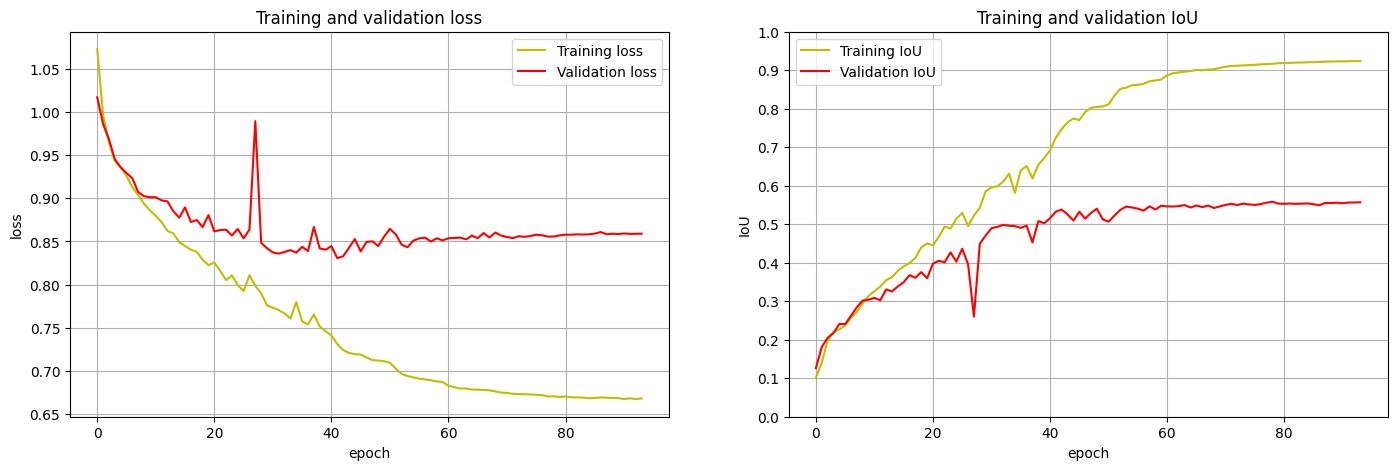

In [ ]:
def plotModel(history, save=None):
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 2, 1)
    plt.plot([h.get('train_loss') for h in history], 'y', label='Training loss')
    plt.plot([h.get('val_loss') for h in history], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch'), plt.ylabel('loss')
    plt.legend(), plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot([h.get('train_iou') for h in history], 'y', label='Training IoU')
    plt.plot([h.get('val_iou')   for h in history], 'r',  label='Validation IoU')
    plt.title('Training and validation IoU')
    plt.xlabel('epoch'), plt.ylabel('IoU')
    plt.legend(), plt.grid(), plt.gca().set_ylim(0, 1), plt.yticks([c/10 for c in range(11)])
    
    if not save:
        return plt.show()

    os.makedirs(os.path.dirname(save), exist_ok=True)
    plt.savefig(save, dpi=300, bbox_inches='tight', facecolor='white')
    plt.close()


plotModel(trainer.history)

# DADOS DE TESTE

In [ ]:
xTest = np.array([np.load(path) for path in getFiles('database/processed/test/images')])
yTest = np.array([np.load(path) for path in getFiles('database/processed/test/masks')])

test_loader = getLoader(xTest,  yTest, 1, shuffle=False)
test_loss, test_iou = trainer.evaluate(test_loader)
test_iou

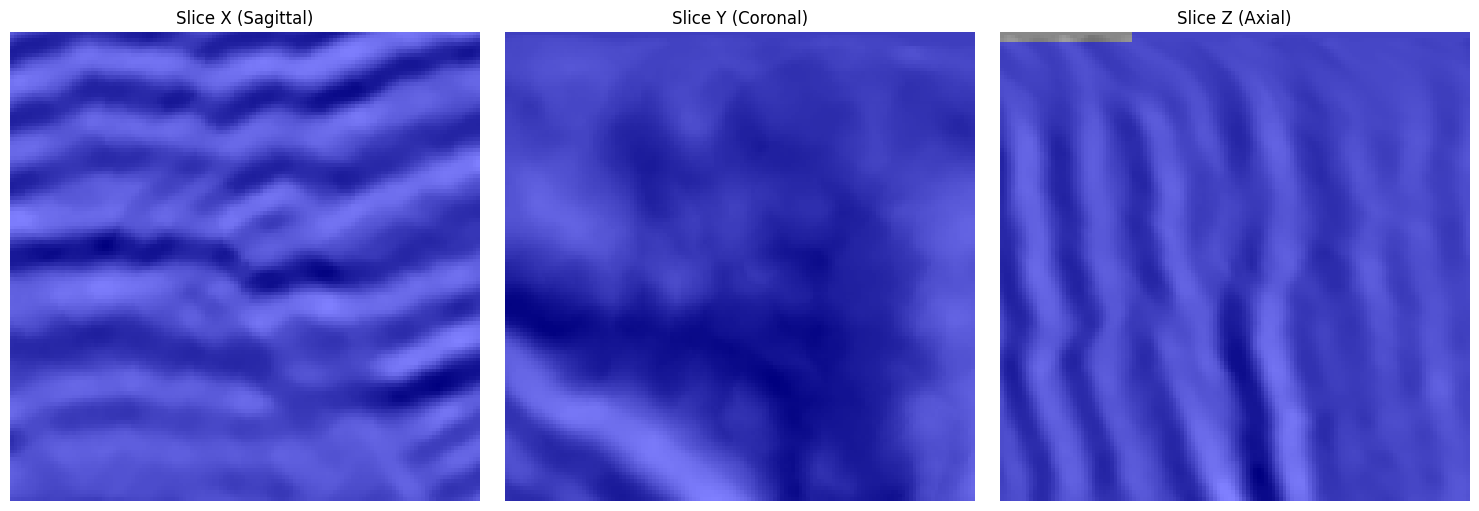

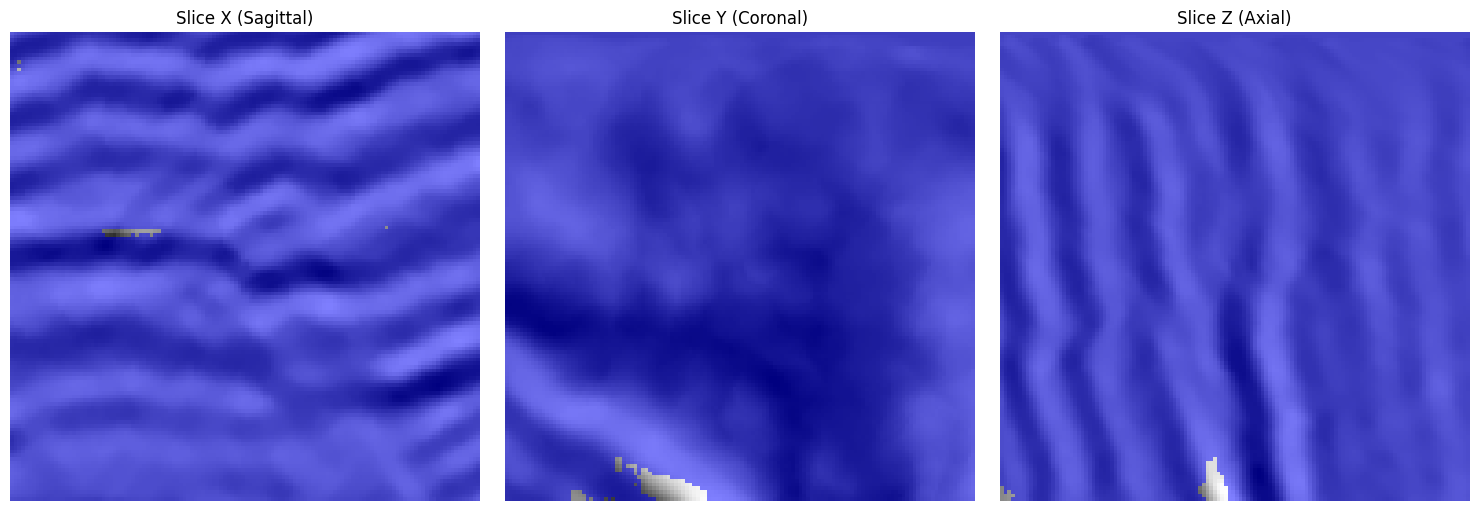

In [ ]:
trainer.network.model.eval()
yModel = []

with torch.no_grad():
    for (imgs, masks) in test_loader:
        imgs, masks = imgs.to(trainer.network.device), masks.to(trainer.network.device)

        with amp.autocast('cuda', enabled=trainer.use_amp):
            outs = torch.sigmoid(trainer.network.model(imgs)) if not trainer.network.multiclass else trainer.network.model(imgs)

        preds = torch.argmax(outs, dim=1) if trainer.network.multiclass else outs
        pred  = preds.cpu().numpy()[0]

        if not trainer.network.multiclass:
            pred = pred[0]

        yModel.append(pred)


pasteMask(xTest[0], yTest[0])
pasteMask(xTest[0], yModel[0])

# VISUALIZAÇÃO FINAL

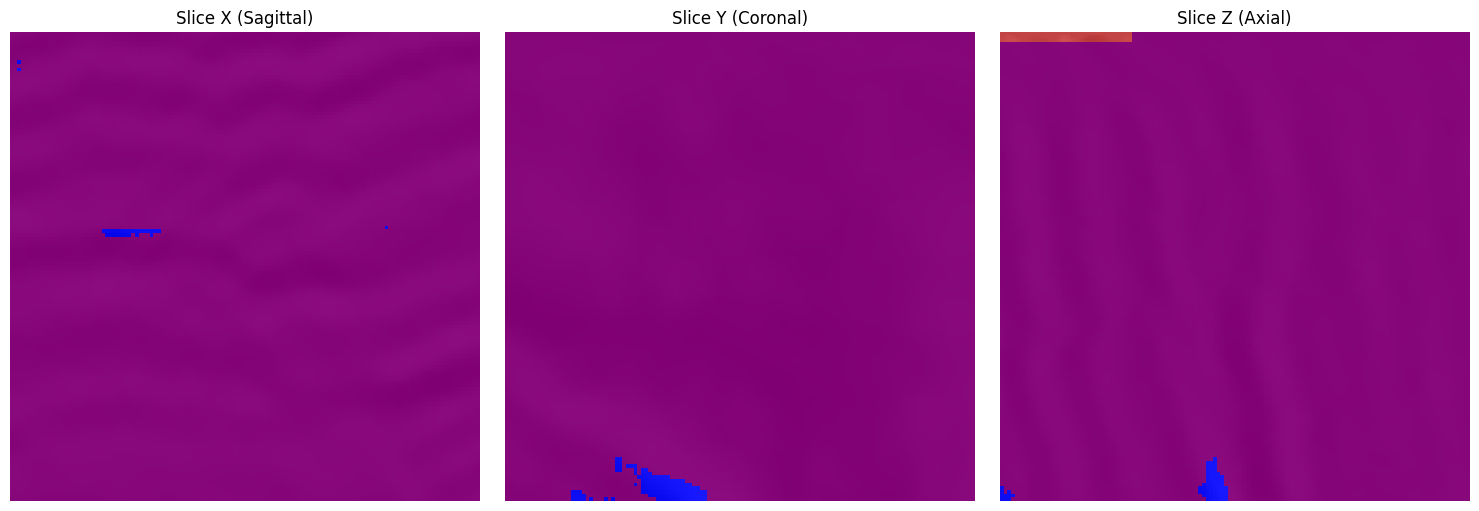

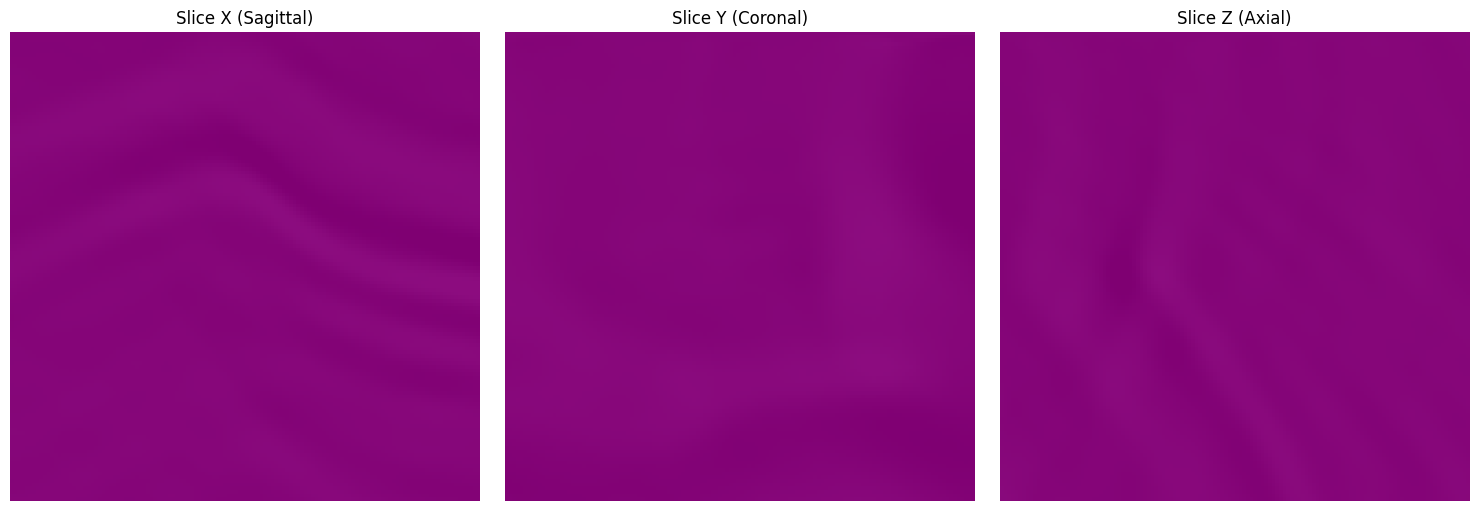

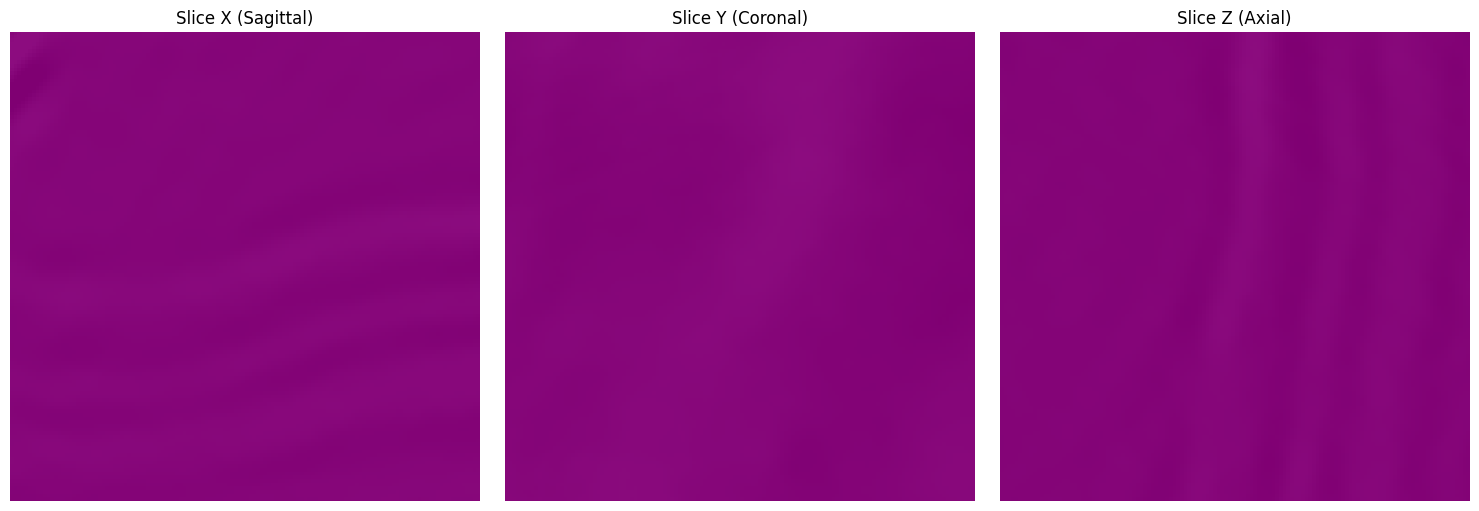

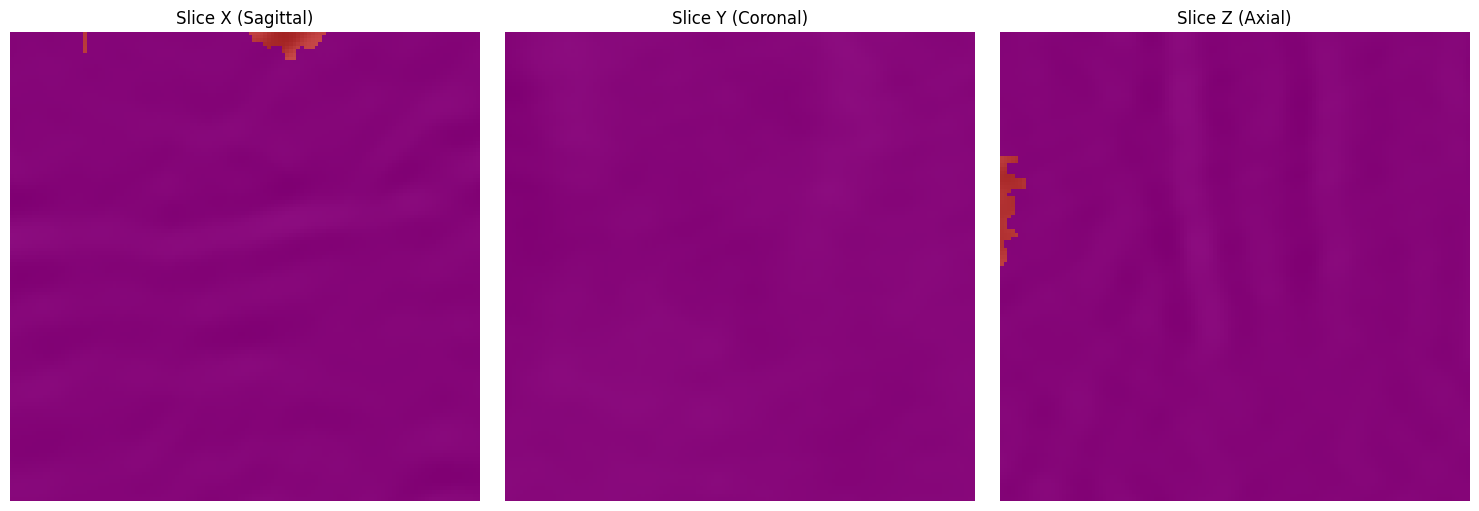

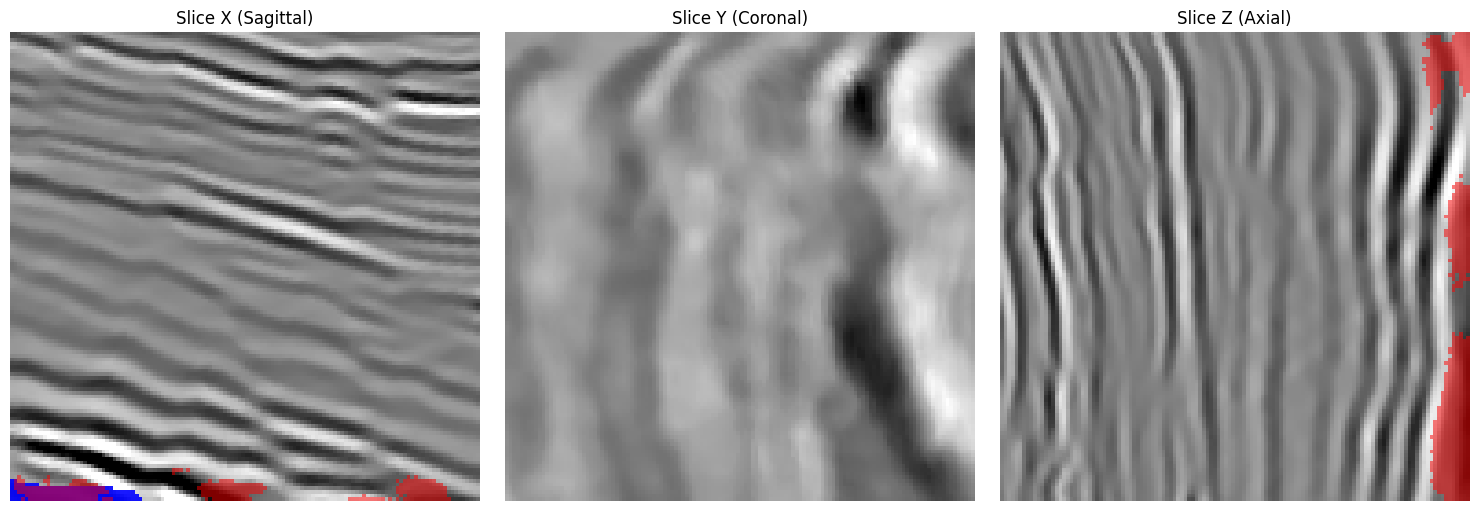

In [ ]:
def comparePredictions(img, mask, pred):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    mid = img.shape[0] // 2
    
    slices = [
        (img[mid, :, :], mask[mid, :, :], pred[mid, :, :], 'Slice X (Sagittal)'),
        (img[:, mid, :], mask[:, mid, :], pred[:, mid, :], 'Slice Y (Coronal)'),
        (img[:, :, mid], mask[:, :, mid], pred[:, :, mid], 'Slice Z (Axial)')
    ]

    color_gt   = np.array([0, 0, 255]) 
    alpha_gt   = 0.9
    
    color_pred = np.array([255, 0, 0])
    alpha_pred = 0.5

    for i, (img_slice, m_gt, m_pred, title) in enumerate(slices):
        img_norm = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        canvas   = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2RGB)
        mask_indices      = (m_gt > 0)
        mask_indices_pred = (m_pred > 0)

        if np.any(mask_indices):
            roi = canvas[mask_indices]
            blended = (roi.astype(float) * (1 - alpha_gt) + color_gt.astype(float) * alpha_gt)
            canvas[mask_indices] = blended.astype(np.uint8)

        if np.any(mask_indices_pred):
            roi = canvas[mask_indices_pred]
            blended = (roi.astype(float) * (1 - alpha_pred) + color_pred.astype(float) * alpha_pred)
            canvas[mask_indices_pred] = blended.astype(np.uint8)

        axes[i].imshow(canvas)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()


for i in range(min(len(xTest), 5)):
    p_mask = (yModel[i] > 0.5 )
    comparePredictions(xTest[i], yTest[i], p_mask)
    plt.show()

# SALVANDO O MODELO

In [ ]:
from datetime import datetime
import json, inspect

In [ ]:
info = processing_options
info.update(network.info())

info.update({
    'timestamp':  datetime.now().strftime('%d/%m/%y %H:%M:%S'),
    'classes':    classes, 
    'batch_size': batch_size, 
    'criterion':  selected_loss,
    'val_iou': trainer.history[-1].get('val_iou'), 'test_iou': test_iou
})

data = {
    'model': network.model.state_dict(),
    'optimizer': network.optimizer.state_dict(),
    'timestamp': datetime.now().strftime('%d/%m/%y %H:%M:%S'),
    'history': trainer.history,
}

def saveModel(info, data):
    os.makedirs('backup/', exist_ok=True)
    id     = 1 if len(os.listdir('backup/')) == 0 else max([int(path.split('_')[-1]) for path in os.listdir('backup/')]) + 1
    folder = f'backup/model_{id}'
    os.makedirs(folder, exist_ok=True)

    with open(f'{folder}/info.json', 'w', encoding='utf-8') as file:
        json.dump(info, file, ensure_ascii=False, indent=4)
    
    plotModel(data['history'], f'{folder}/train.png')
    torch.save(data, f'{folder}/data.pth')
    print('model saved in', folder)
    

saveModel(info, data)

model saved in backup/model_2
